# In the Name of God

# Imports:

In [1]:
# from typing import List
import math
import pandas as pd
import numpy as np
import hazm
# from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
import matplotlib.pyplot as plt
import itertools


# Defines:

In [2]:
IGNORE_CASES = ["گزارش", "ایسنا"]
MIN_FREQ_IN_TRAIN_DATA = 60
BIGRAM_WEIGHT = 5
INITIAL_SCORE = 1000

# Lemmatization vs Stemming:

In [3]:
stemmer = hazm.Stemmer()
print(stemmer.stem("می‌رفتم"))
lemmatizer = hazm.Lemmatizer()
print(lemmatizer.lemmatize("می‌رفتم").split("#")[0])

می‌رف
رفت


# Phase 1:

In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data
# train_data["content"][3]
i = 0
for index, row in train_data.iterrows():
    i += 1
    print(index)
    print(row)
    if i == 20:
        break

0
label                                                 فناوری
content    گزارش های منتشر شده حاکی از آن است که کاربران ...
Name: 0, dtype: object
1
label                                                  ورزشی
content    سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
Name: 1, dtype: object
2
label                                                  حوادث
content    مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
Name: 2, dtype: object
3
label                                                 فناوری
content    یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
Name: 3, dtype: object
4
label                                                  سلامت
content    دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
Name: 4, dtype: object
5
label                                                  سلامت
content    مصرف میوه، یکی از راه های سالم برای کاهش وزن س...
Name: 5, dtype: object
6
label                                                  سیاسی
content    رئیس جمهوری پیش‌بینی، پیشگیری و درمان آسیب‌ه

In [5]:

class Parser:
    def __init__(self) -> None:
        self.normalizer = hazm.Normalizer()
        self.lemmatizer = hazm.Lemmatizer()
        self.tokenize = hazm.word_tokenize
        self.stop_words = hazm.stopwords_list()
        self.stop_words = self.stop_words + IGNORE_CASES

    def parse(self, text : str):
        tokens = self.tokenize(self.normalizer.normalize(text))
        tokens = [elem for elem in tokens if elem not in self.stop_words and elem.isalpha()]
        tokens = [self.lemmatize(elem) for elem in tokens if elem not in self.stop_words]
        return tokens

    def unigram_parse(self, text : str):
        tokens = self.parse(text)
        return tokens    

    def bigram_parse(self, text : str):
        tokens = self.parse(text)
        bigram_tokens = []
        for i in range(len(tokens) - 1):
            bigram_tokens.append(tokens[i] + " " + tokens[i + 1])
        return bigram_tokens

    def lemmatize(self, word :str) -> str:
        return self.lemmatizer.lemmatize(word).split('#')[0]

p = Parser()
tokens = p.bigram_parse(train_data["content"][3])
print(tokens)
        

['نوجوان انگلیسی', 'انگلیسی اتهام', 'اتهام هک', 'هک کاربر', 'کاربر ایمیل', 'ایمیل ارشد', 'ارشد آمریکایی', 'آمریکایی سال', 'سال حبس', 'حبس دارالتادیب', 'دارالتادیب محکوم', 'محکوم نقل', 'نقل خبرگزاری', 'خبرگزاری آسوشیتدپرس', 'آسوشیتدپرس نوجوان', 'نوجوان نام', 'نام کین', 'کین گمبل', 'گمبل بازه', 'بازه زمان', 'زمان اقدام', 'اقدام هک', 'هک دسترس', 'دسترس اطلاعات', 'اطلاعات کاربر', 'کاربر مارک', 'مارک جیلیانو', 'جیلیانو مدیر', 'مدیر وقت', 'وقت اف', 'اف آی', 'آی جی', 'جی جانسون', 'جانسون وزیر', 'وزیر وقت', 'وقت کشور', 'کشور جان', 'جان برن', 'برن رئیس', 'رئیس وقت', 'وقت سیا', 'سیا گمبل', 'گمبل عضو', 'عضو گروه', 'گروه هکری', 'هکری موسوم', 'موسوم Crackas', 'Crackas With', 'With Attitude', 'Attitude اطلاعات', 'اطلاعات صورت', 'صورت آنلاین', 'آنلاین منتشر', 'منتشر گمبل', 'گمبل سال', 'سال گذشته', 'گذشته میلاد', 'میلاد گناهکار', 'گناهکار نوجوان', 'نوجوان انگلیسی', 'انگلیسی روز', 'روز جمعه', 'جمعه دادگاه', 'دادگاه کیفر', 'کیفر لندن', 'لندن سال', 'سال حبس', 'حبس دارالتادیب', 'دارالتادیب محکوم', 'محکوم 

In [6]:
class Topic:
    def __init__(self, name) -> None:
        self.name = name
        self.words = {}
        self.N = 0
        self.sorted = False


    def sort_words(self):
        if self.sorted:
            return
        self.words = {k: v for k, v in sorted(self.words.items(), key=lambda item: item[1], reverse=True) if v >= MIN_FREQ_IN_TRAIN_DATA}
        for count in self.words.values():
            self.N += count
        self.sorted = True
    
    def add(self, tokens, alpha = 1):
        for t in tokens:
            if t in self.words:
                self.words[t] += alpha
            else:
                self.words.update({t: alpha})

    def plot(self, n :int):
        self.sort_words()
        result = dict(itertools.islice(self.words.items(), n))
        plt.bar(result.keys(), result.values())
        plt.xlabel(self.name)
        plt.ylabel('frequency')
        plt.show()    

    def cal_score(self, content):
        self.sort_words()
        score = INITIAL_SCORE
        minimum_score = math.log2(1/ self.N)
        for w in content:
            if w in self.words:
                score += math.log2(self.words[w]/ self.N)
            else:
                score += minimum_score
        print(f"score is :{score}")
        return score

topics = {}

def train():
    for index, row in train_data.iterrows():
        label = row["label"]
        text = row["content"]
        unigram_content = p.unigram_parse(text)
        bigram_content = p.bigram_parse(text)

        if label not in topics:
            topics.update({label: Topic(label)})

        topics[label].add(unigram_content)    
        topics[label].add(bigram_content, BIGRAM_WEIGHT)    

train()

In [7]:
# math.log2(1/1024)

# x = {"1" : 1 ,
#     "b" : 2
# }

# "b" in x

# Pase 2:

In [8]:
def predict_category(content):
    max_score = -math.inf
    chosen_topic = ""
    for t in topics:
        if(topics[t].cal_score(content) > max_score):
            max_score = topics[t].cal_score(content)
            chosen_topic = t
    return chosen_topic

In [11]:
def predict():
    for index, row in test_data.iterrows():
        label = row["label"]
        text = row["content"]
        unigram_content = p.unigram_parse(text)
        bigram_content = p.bigram_parse(text)
        predicted_label = predict_category(unigram_content + bigram_content)
        print(predicted_label)

In [12]:
predict()

score is :-3683.1852742679907
score is :-3683.1852742679907
score is :-4038.0183384099523
score is :-4003.8088620549765
score is :-4229.1604829306525
score is :-3837.618424950488
score is :-3938.454836602838
فناوری
score is :-7888.825601479534
score is :-7888.825601479534
score is :-8000.759273250926
score is :-7976.573663261808
score is :-8344.181361782477
score is :-7795.342102077427
score is :-7795.342102077427
score is :-7484.925236133038
score is :-7484.925236133038
فرهنگی/هنری
score is :-1298.482403068022
score is :-1298.482403068022
score is :-1303.2657268610892
score is :-1081.2789621465515
score is :-1081.2789621465515
score is :-1381.4016493588513
score is :-1292.7003314036053
score is :-1241.9314739236395
حوادث
score is :-4647.694091846583
score is :-4647.694091846583
score is :-5423.84368736143
score is :-5321.237761325851
score is :-5502.489727737236
score is :-5248.092837187358
score is :-5238.253383882372
فناوری
score is :-1186.7829898346245
score is :-1186.7829898346245

KeyboardInterrupt: 

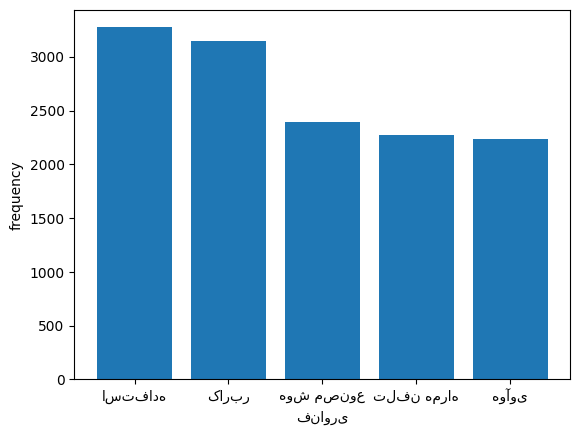

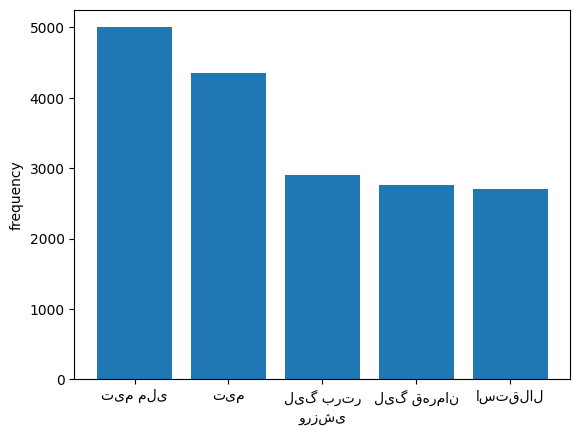

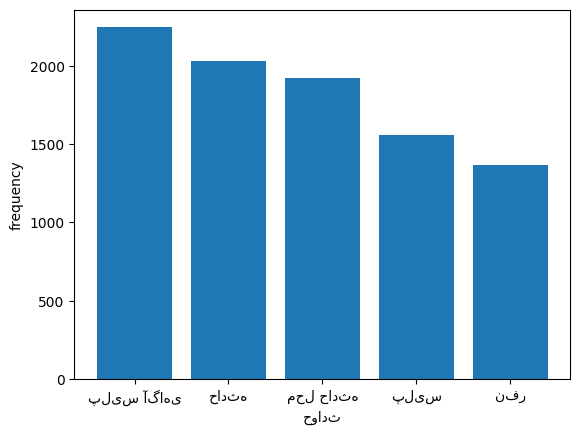

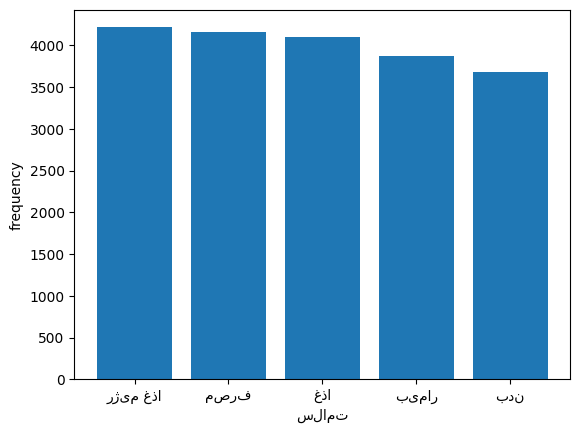

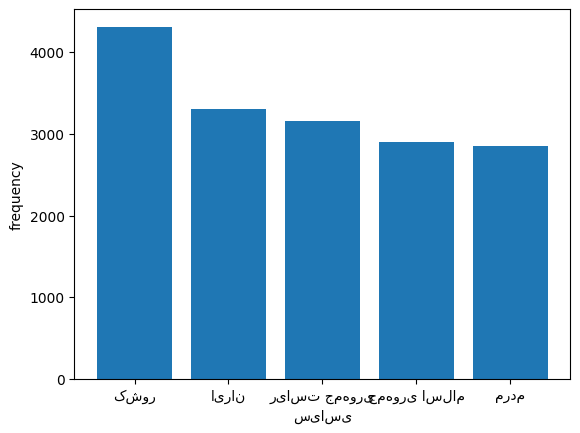

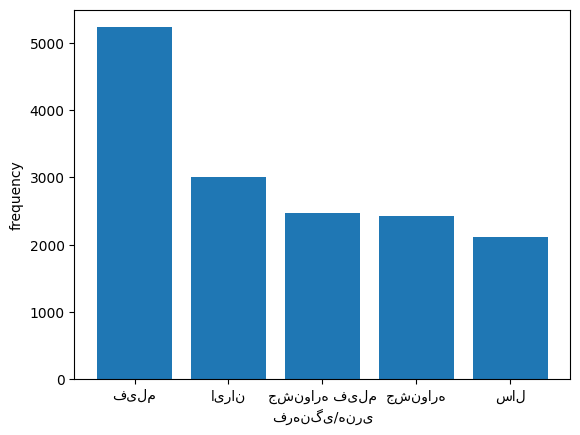

In [ ]:
for topic in topics.values():
    topic.plot(5)

In [ ]:
x = topics["سیاسی"].words
len(x)
print(x)

{'کشور': 4308, 'ایران': 3305, 'ریاست جمهوری': 3160, 'جمهوری اسلام': 2905, 'مردم': 2847, 'شورا نگهبان': 2575, 'دولت': 2338, 'شورا اسلام': 2280, 'مجلس شورا': 2145, 'مجلس': 2071, 'رئیس جمهور': 2010, 'اسلام': 1987, 'شورا': 1857, 'انتخابات': 1853, 'امور خارجه': 1780, 'انتخابات ریاست': 1775, 'اسلام ایران': 1660, 'سال': 1644, 'کار': 1580, 'جمهوری': 1576, 'انقلاب اسلام': 1490, 'رئیس': 1480, 'قانون اساس': 1450, 'قوه قضاییه': 1435, 'انقلاب': 1296, 'قانون': 1274, 'اقتصاد': 1265, 'روز': 1246, 'قرار': 1220, 'نظام': 1199, 'انجام': 1150, 'سیاسی': 1147, 'رییس جمهور': 1115, 'مقام معظم': 1110, 'معظم رهبر': 1100, 'ادامه': 1011, 'وزیر': 961, 'اصلاح طلب': 960, 'امنیت ملی': 950, 'آمریکا': 938, 'مجمع تشخیص': 915, 'امروز': 914, 'وزارت': 911, 'ثبت نام': 910, 'سردار سلیمان': 905, 'اشاره': 904, 'صورت': 902, 'عنوان': 901, 'حضور': 898, 'کرد': 892, 'ملت ایران': 890, 'وزارت امور': 890, 'داشت': 885, 'رهبر': 881, 'آیت الله': 880, 'شهید سلیمان': 870, 'فضا مجاز': 855, 'دست': 846, 'سیاست خارج': 840, 'وزیر امور': 835, 'ری